### Global Market Clusteing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
import random
import datetime
import warnings
from datetime import date
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import pickle
import seaborn as sn
import os
os.chdir('../')

from src.test_pipeline import test_pipeline
from src.test_pipeline import Hierarchical_Computing
import pandas_bokeh
pandas_bokeh.output_notebook()

plt.rcParams["figure.figsize"] = (18,5)
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
dfs = []
names = []
for counter,df in enumerate(os.listdir("data/global_market")):
    if df != "inflation_USA_data.csv":
        names.append(df.split("_data.csv")[0])
        dfs.append(pd.read_csv(f"data/global_market/{df}"))
        dfs[counter]["Date"] = pd.to_datetime(dfs[counter]["Date"])
        dfs[counter].set_index("Date",inplace=True)
        #dfs[counter].replace(0,0.000000001,inplace=True)


column_names = []
terminations = ["Var","Diff"]
for i in names:
    for j in terminations:
        column_names.append(i+"_"+j)


gdps = []
for counter,df in enumerate(os.listdir("data/GDP")):
    gdps.append(pd.read_csv(f"data/GDP/{df}"))
    gdps[counter]["Date"] = pd.to_datetime(gdps[counter]["Date"])
    gdps[counter].set_index("Date",inplace=True)
    column_names.append(df.split("_data.csv")[0])



inflation = pd.read_csv("data/global_market/inflation_USA_data.csv")
inflation["Date"] = pd.to_datetime(inflation["Date"])
inflation.set_index("Date",inplace=True)

column_names.append("inflation_USA")

column_names.append("Date")


In [4]:
from sklearn.preprocessing import StandardScaler
from src.clustering_functions import calculate_cluster_variables

df = calculate_cluster_variables(start="2016-01-01",end="2018-12-01",terminations=terminations,colnames=column_names,dfs=dfs,gdps=gdps,inflation=inflation,verbose=True,column_name="Average")
df.fillna(method="pad",axis=1,inplace=True)

normalizer = StandardScaler()
normalizer.fit(df)
df_normalized = normalizer.transform(df)

2016-01-01
2016-02-01
2016-03-01
2016-04-01
2016-05-01
2016-06-01
2016-07-01
2016-08-01
2016-09-01
2016-10-01
2016-11-01
2016-12-01
2017-01-01
2017-02-01
2017-03-01
2017-04-01
2017-05-01
2017-06-01
2017-07-01
2017-08-01
2017-09-01
2017-10-01
2017-11-01
2017-12-01
2018-01-01
2018-02-01
2018-03-01
2018-04-01
2018-05-01
2018-06-01
2018-07-01
2018-08-01
2018-09-01
2018-10-01
2018-11-01
2018-12-01


In [7]:
from sklearn.decomposition._pca import PCA

df_test = calculate_cluster_variables(start="2019-01-01",end="2019-12-01",terminations=terminations,colnames=column_names,dfs=dfs,gdps=gdps,inflation=inflation,verbose=False,column_name="Average")
df_test.fillna(method="pad",axis=1,inplace=True)

df_normalized_test = normalizer.transform(df_test)


In [89]:
#Calculating the nearest neighbour of our test to the train
indexes = []

for i in np.array(df_normalized_test):
    distances = []
    for j in np.array(df_normalized):
        distances.append(np.linalg.norm(i-j))
    min_value = min(distances)
    indexes.append(distances.index(min_value))  
    
end_dates = []
for i in indexes:
    end_dates.append(str(pd.DataFrame(df.iloc[i,:]).columns)[16:26])

In [99]:
end_dates


['2018-11-01',
 '2018-02-01',
 '2018-02-01',
 '2018-01-01',
 '2018-01-01',
 '2018-04-01',
 '2017-03-01',
 '2017-04-01',
 '2017-04-01',
 '2017-04-01',
 '2017-04-01',
 '2017-04-01']

In [90]:
indexes

[34, 25, 25, 24, 24, 27, 14, 15, 15, 15, 15, 15]

In [75]:
train = pd.read_csv("data/prices_train.csv")
train.set_index("Unnamed: 0",inplace=True)
train.index.name= 'date'
test = pd.read_csv("data/prices_test.csv")
test.set_index("Unnamed: 0",inplace=True)
test.index.name= 'date'

with open('data/different_funds_10.pkl', 'rb') as f: #Cleaning duplicated name funds
    DifferentNameFunds = pickle.load(f)
    
train = train[DifferentNameFunds]
test = test[DifferentNameFunds]

In [103]:
end = "2018-11-01" 
start = (date.fromisoformat(end) - relativedelta(years=1)).isoformat()

selected_funds = Hierarchical_Computing(train[start:end],test,market_neutral=False,n_steps=1,split_size=500,print_every=20,
                                        min_weight=0.001,add_leftovers=False,method="CVaR",risk=0.05,risk_level=4,gamma=0.2,solver='CPLEX')

weights,returns,info_dict = test_pipeline(train[selected_funds][start:end],test["2019-08-01":],market_neutral=True,
                        min_weight=0.04,add_leftovers=True,samples=0,method="CVaR",
                        risk=0.005,risk_level=4,budget=500,gamma=0.15,rs=40,solver='CPLEX') #Methods = CDaR, CVaR, sharpe, MAD, ML

Iteration 1
-----------
Selected funds in step 1: 117 

Using CVaR method
Using pypfopt...
Expected annual return: 18.9%
Conditional Value at Risk: 5.00%
Optimization time: 0.6128866672515869 seconds
Budget not inverted: 0.0$
Volatility obtained in test: 0.12560205518544393
Total return obtained in the test year: 21.53%
Money obtained during test year: 107.63$
Distributed in 7 funds:
{'THREADNEEDLE EMERGING MARKET BOND "2"': 0.21278857142857144, 'JPM US TECHNOLOGY "A" (GBP) D': 0.21039857142857143, 'BGF WORLD MINING "ADS" GBP INC': 0.18098857142857144, 'JPM BRAZIL EQUITY "D" (USD) ACC': 0.18066857142857143, 'SANTANDER AM BRAZILIAN EQ "AE" EUR ACC': 0.08305857142857143, 'JAN HEN GLOBAL TECHNOLOGY "I" (USD) ACC': 0.07212857142857143, 'BGF LATIN AMERICAN "ADS" (GBP) INC': 0.05995857142857143}


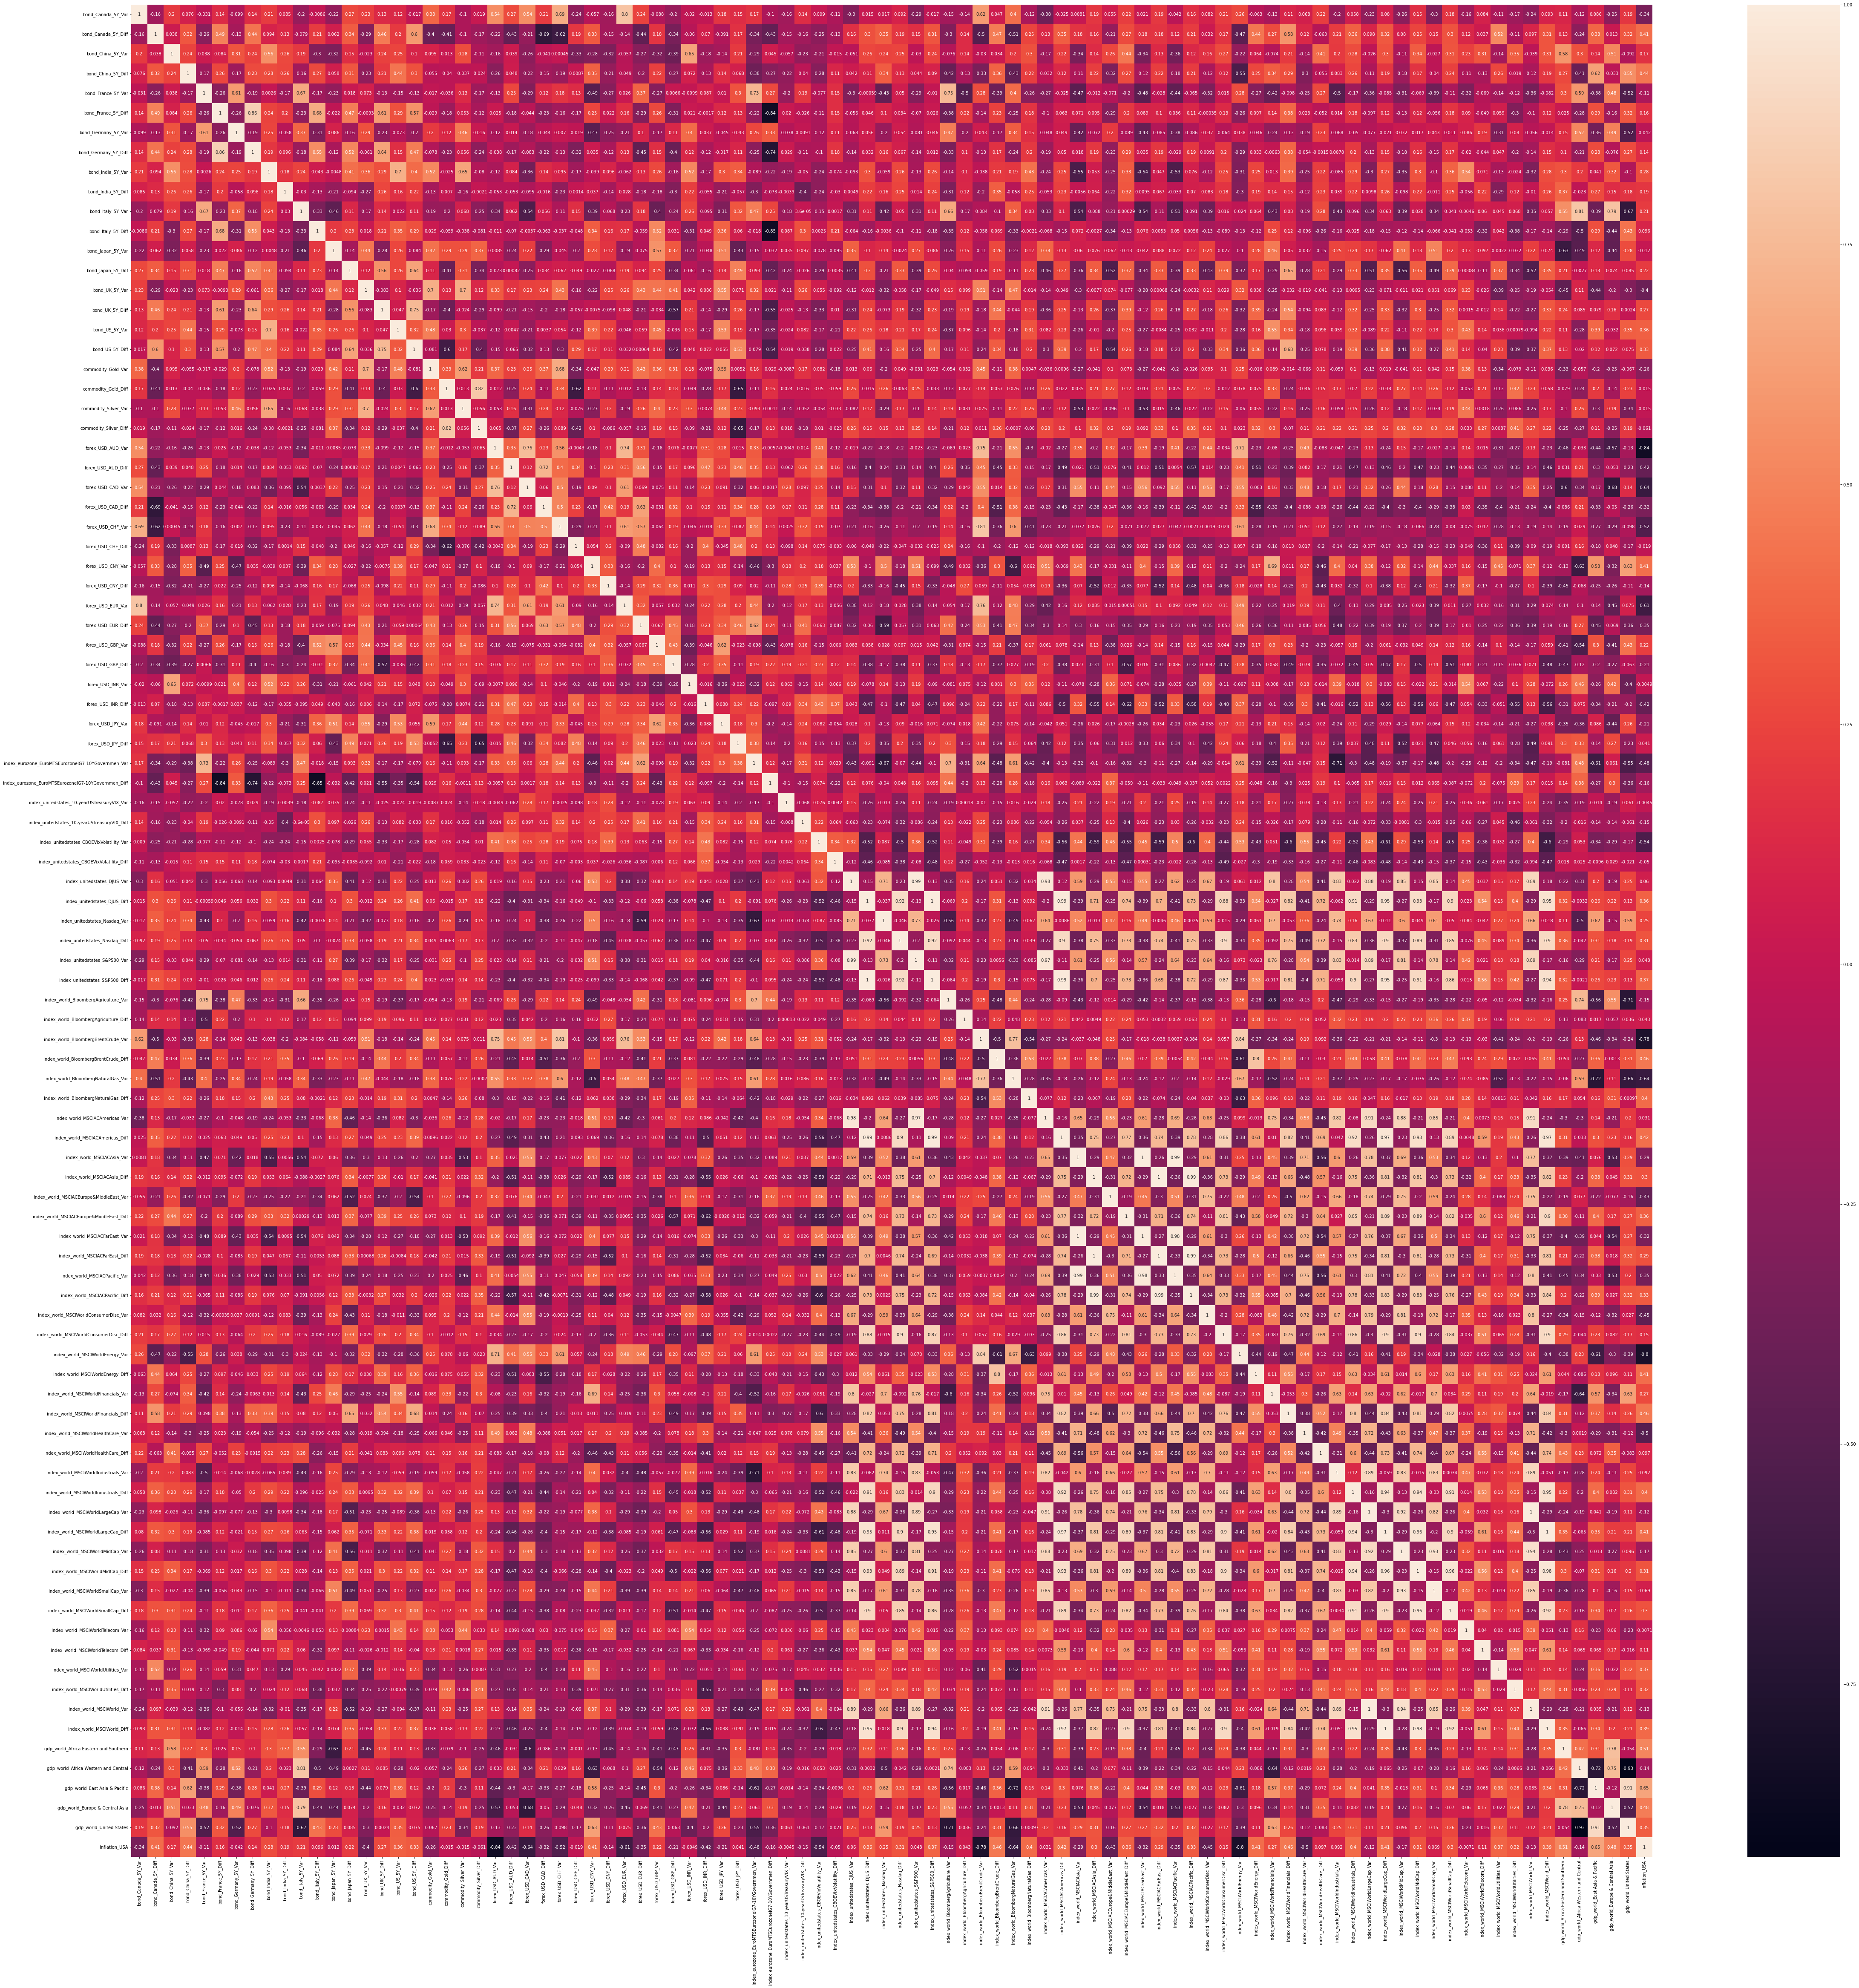

In [6]:
# Correlation matrix

plt.rcParams['figure.figsize'] = 80,80
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

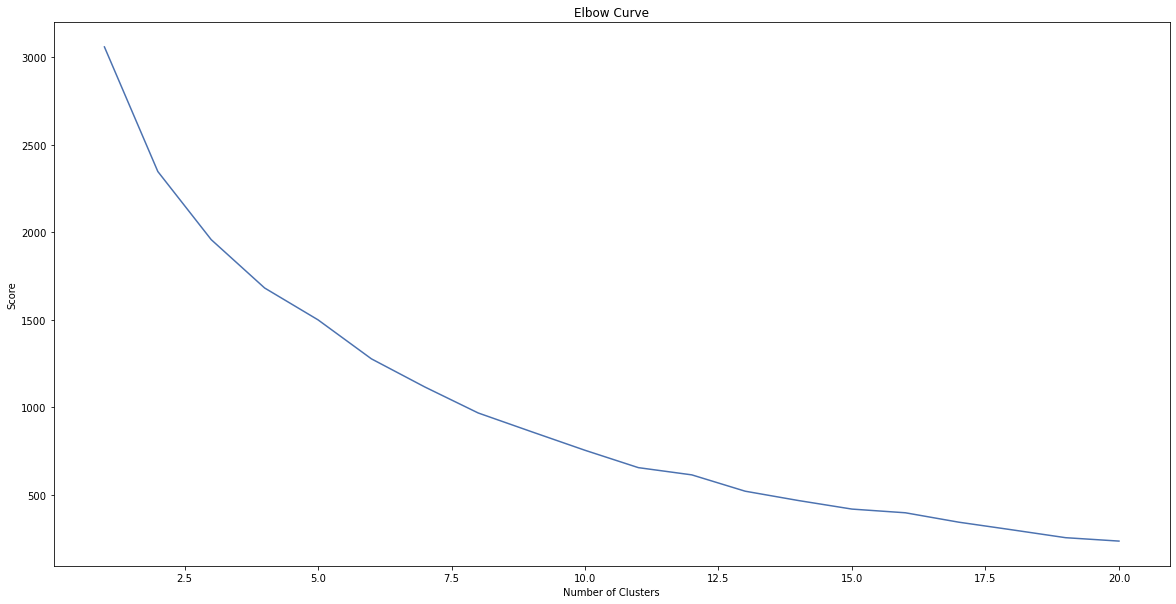

In [92]:
from src.clustering_functions import plot_elbow_graph
plt.rcParams['figure.figsize'] = 20,10
plot_elbow_graph(df_normalized,use_PCA=True,n_pca_components=13,verbose=True,n_clusters=20)

Test labels: [0 3 3 2 2 0 4 4 1 4 4 4]
Train labels: [1 0 3 3 3 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 3 0 0 2 2 2 2 2 2 0 0]
(array([0, 1, 2, 3, 4]), array([ 5,  9,  6,  4, 12], dtype=int64))


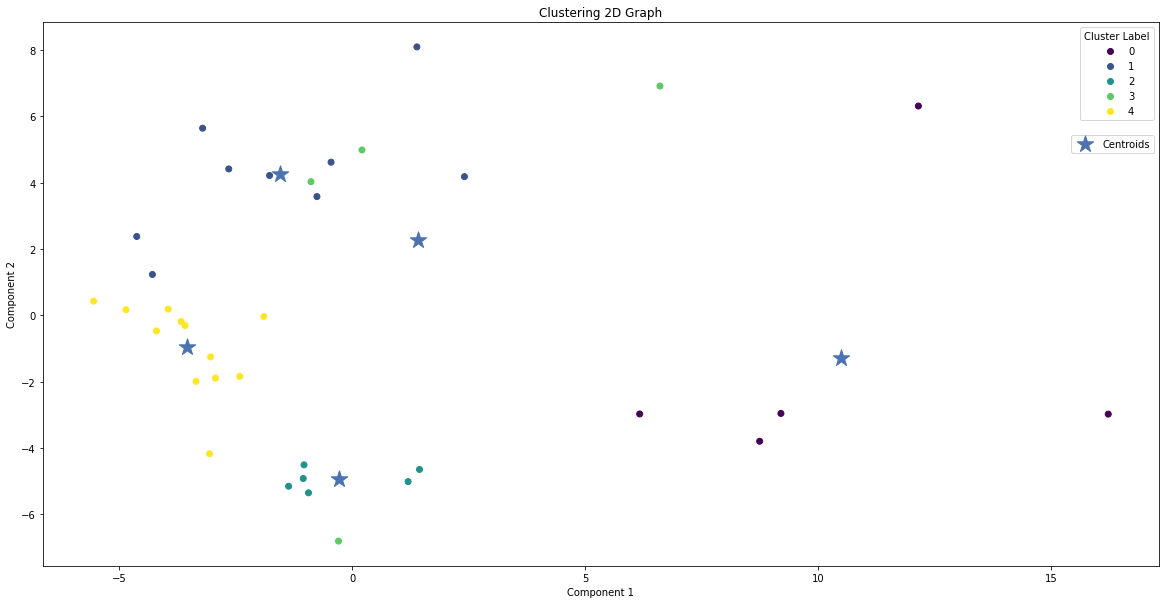

In [120]:
from src.clustering_functions import make_clustering

from sklearn.decomposition._pca import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

kmeans,pca,labels = make_clustering(df_normalized,use_PCA=True,n_clusters=5,n_pca_components=13,verbose=True)

if pca == None:
    df_pca_test = df_normalized_test
else:
    df_pca_test = pca.transform(df_normalized_test)

test_labels = kmeans.predict(df_pca_test)
print("Test labels:", test_labels)
print("Train labels:", labels)
#print(pca.explained_variance_ratio_.cumsum())

list_indices = []
for i in set(labels):
  indices = []
  for j in range(len(labels)):
      if labels[j] == i:
        indices.append(j)
  list_indices.append(indices)

print(np.unique(labels, return_counts=True))

In [217]:
dates_list = []
for i in set(labels):
  dates = []
  for j in df.iloc[list_indices[i],:].index:
    dates.append(str(j)[0:10])

  dates_list.append(dates)
  
#Takes just the train dates that equals the ones on the clustering

# clustering_selection_dfs = []

# for i in dates_list:
#     clustering_selection_df = []
#     for j in i:
#         start = j
#         end = (date.fromisoformat(j) + relativedelta(months=1) - relativedelta(days=1)).isoformat()
#         clustering_selection_df.append(train[start:end])

#     clustering_selection_dfs.append(pd.concat(clustering_selection_df))


#Takes the range from the first cluster date to the last

clustering_selection_dfs = []

for i in dates_list:
    clustering_selection_df = []
    start = i[0]
    end = (date.fromisoformat(i[-1]) + relativedelta(months=1) - relativedelta(days=1)).isoformat()

    clustering_selection_dfs.append(train[start:end])

In [226]:
selected_funds = Hierarchical_Computing(clustering_selection_dfs[2],test,market_neutral=False,n_steps=1,split_size=500,print_every=20,
                                        min_weight=0.001,add_leftovers=False,method="CVaR",risk=0.05,risk_level=3,gamma=0.2,solver='CPLEX')

weights,returns,info_dict = test_pipeline(clustering_selection_dfs[2][selected_funds],test,market_neutral=True,
                        min_weight=0.04,add_leftovers=True,samples=0,method="CVaR",
                        risk=0.005,risk_level=3,budget=500,gamma=0.15,rs=40,solver='CPLEX') #Methods = CDaR, CVaR, sharpe, MAD, ML

Iteration 1
-----------
Selected funds in step 1: 97 

Using CVaR method
Using pypfopt...
Expected annual return: 23.2%
Conditional Value at Risk: 0.50%
Optimization time: 0.5585384368896484 seconds
Budget not inverted: 0.0$
Volatility obtained in test: 0.08964002423138584
Total return obtained in the test year: 20.19%
Money obtained during test year: 100.97$
Distributed in 7 funds:
{'FIDELITY GB HEALTHCARE "Y" (EUR) D': 0.2967328571428572, 'JPM GLOBAL HEALTHCARE "C" (EUR) ACC': 0.18790285714285715, 'BGF WORLD HEALTHSCIENCE "C2" (EUR)': 0.15526285714285715, 'T ROWE PRICE GLOBAL H "A" (EUR) D': 0.12864285714285714, 'FRANKLIN GLB CONV SEC "I" (EUR)': 0.08054285714285714, 'JAN HEN GLB LF SCIN "I" (EUR) ACC A': 0.07602285714285714, 'SEEYOND EQ VOL STRAT "R" (EUR)  ACC': 0.07488285714285714}
